# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [1]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from reco.plotting import plot_sim_reco, plot_remapped, plot_tracksters
from reco.evaluation import evaluate, evaluate_remapped, run_evaluation
from reco.event import remap_arrays_by_label, remap_items_by_label, get_bary, get_lc
from reco.energy import get_total_energy
from reco.dataset import get_ground_truth

%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/Data/multi/new_ntuples_14992862_996.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 123, tracksters sim: 37
Simulated energy: 2886.56, reconstructed energy: 2886.56 (100.00%)


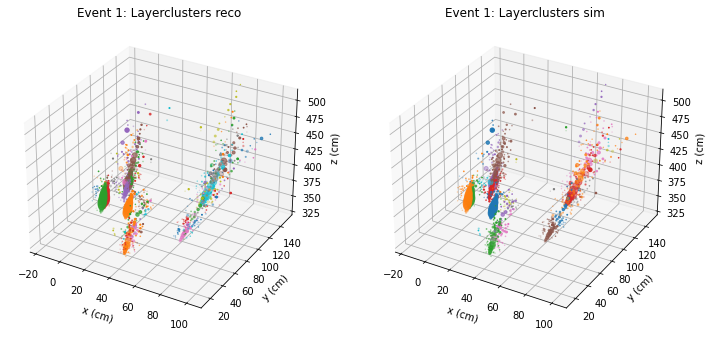

In [2]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]

gt = get_ground_truth(
    tracksters,
    simtracksters,
    associations,
    eid
)

gt_i = gt["vertices_indexes"]
gt_e = gt["vertices_energy"]
gt_m = gt["vertices_multiplicity"]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(gt_i)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(gt_e, gt_m)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")


vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]

plot_sim_reco(
    vx,
    vy,
    vz,
    t_energy,
    gt["vertices_x"],
    gt["vertices_y"],
    gt["vertices_z"],
    gt_e, 
    gt_i,
    gt_m,
    eid,
    legend=False
)

In [3]:
precision, recall, fscore = evaluate(t_indexes, gt_i, t_energy, gt_e, v_multi, gt_m)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 1.00, Recall: 0.43, F-score: 0.60


## k-means

Apply k-means algorithm on CLUE3D barycentres and on layerclusters

Centres: 37


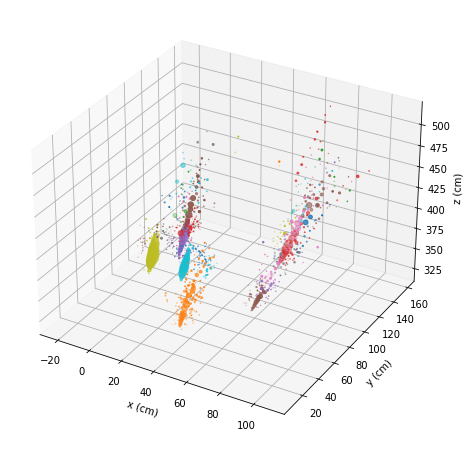

(0.575966939628108, 0.5790499272826337, 0.5775043188778481)

In [4]:
# kmeans on barycentres
K = len(gt_i)

print("Centres:", K)

def kmeans_bary(tracksters, _eid, K=10):
    X_bary = get_bary(tracksters, _eid)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary)
    return kmeans.labels_

labels = kmeans_bary(tracksters, eid, K=K)

plot_remapped(tracksters, eid, labels)
evaluate_remapped(t_indexes, gt_i, t_energy, gt_e, v_multi, gt_m, labels)

Precision: 0.39, Recall: 0.77, F-score: 0.52


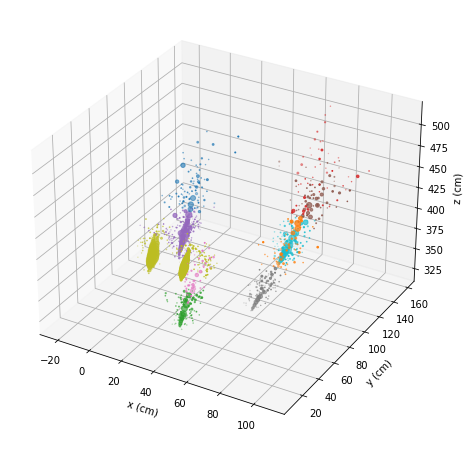

In [5]:
# kmeans on layerclusters
K = 10

X_vertices = get_lc(tracksters, eid)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), kmeans.labels_)

precision, recall, fscore = evaluate(ri, gt_i, re, gt_e, rm, gt_m, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), kmeans.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), kmeans.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), kmeans.labels_)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), kmeans.labels_)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

## GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

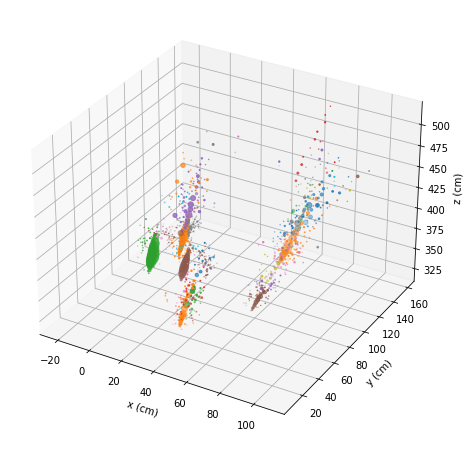

(0.6265183560086267, 0.6284298481506021, 0.6274726463214417)

In [6]:
K = len(gt_i)

def gmm_bary(tracksters, _eid, K=10):
    # gmm on barycentres
    X_bary = get_bary(tracksters, _eid)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)

    # gmm.predict_proba(X) - gives multiplicity?
    return gmm.predict(X_bary)

gmm_labels = gmm_bary(tracksters, eid, K=K)

plot_remapped(tracksters, eid, gmm_labels)
evaluate_remapped(t_indexes, gt_i, t_energy, gt_e, v_multi, gt_m, gmm_labels)

Precision: 0.58, Recall: 0.41, F-score: 0.48


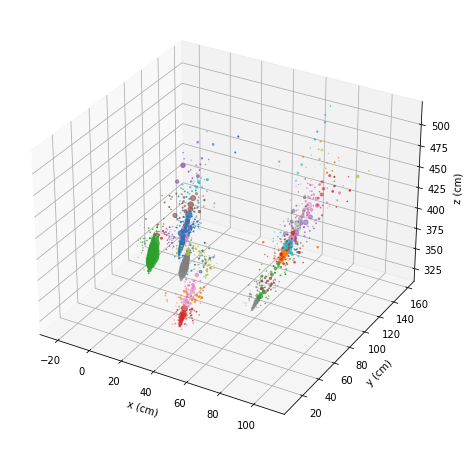

In [7]:
# gmm on layerclusters
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_vertices)
gmm_labels = gmm.predict(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), gmm_labels)
re = remap_items_by_label(ak.flatten(t_energy), gmm_labels)
rm = remap_items_by_label(ak.flatten(v_multi), gmm_labels)

precision, recall, fscore = evaluate(ri, gt_i, re, gt_e, rm, gt_m)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), gmm_labels)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), gmm_labels)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), gmm_labels)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), gmm_labels)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

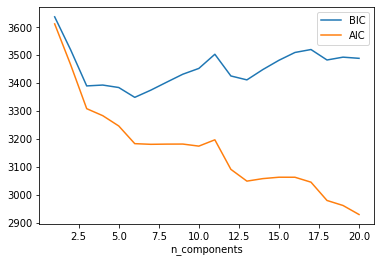

In [8]:
# try to guesstimate the number of components
X = get_bary(tracksters, eid)
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Evaluations

In [11]:
run_evaluation(kmeans_bary, tracksters, simtracksters, associations, K=18)

E0: nTIn: 94	nTSim: 10	nTGt: 19	nTReco: 18	P: 0.77 R: 0.74 F:0.75
E1: nTIn: 123	nTSim: 10	nTGt: 37	nTReco: 18	P: 0.51 R: 0.80 F:0.62
E2: nTIn: 97	nTSim: 10	nTGt: 33	nTReco: 18	P: 0.64 R: 0.85 F:0.73
E3: nTIn: 104	nTSim: 10	nTGt: 39	nTReco: 18	P: 0.63 R: 0.79 F:0.70
E4: nTIn: 76	nTSim: 10	nTGt: 32	nTReco: 18	P: 0.55 R: 0.83 F:0.66
E5: nTIn: 35	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.95 R: 0.66 F:0.78
E6: nTIn: 34	nTSim: 10	nTGt: 12	nTReco: 18	P: 0.82 R: 0.81 F:0.81
E7: nTIn: 36	nTSim: 10	nTGt: 17	nTReco: 18	P: 0.83 R: 0.84 F:0.83
E8: nTIn: 81	nTSim: 10	nTGt: 45	nTReco: 18	P: 0.44 R: 0.80 F:0.56
E9: nTIn: 44	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.83 R: 0.91 F:0.87
E10: nTIn: 97	nTSim: 10	nTGt: 25	nTReco: 18	P: 0.80 R: 0.85 F:0.83
E11: nTIn: 64	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.60 R: 0.77 F:0.68
E12: nTIn: 30	nTSim: 10	nTGt: 10	nTReco: 18	P: 0.89 R: 0.67 F:0.77
E13: nTIn: 108	nTSim: 10	nTGt: 40	nTReco: 18	P: 0.66 R: 0.83 F:0.73
E14: nTIn: 26	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.99 R: 0.92 F:0.95
E1

In [12]:
run_evaluation(gmm_bary, tracksters, simtracksters, associations, K=18)

E0: nTIn: 94	nTSim: 10	nTGt: 19	nTReco: 18	P: 0.70 R: 0.70 F:0.70
E1: nTIn: 123	nTSim: 10	nTGt: 37	nTReco: 18	P: 0.46 R: 0.74 F:0.56
E2: nTIn: 97	nTSim: 10	nTGt: 33	nTReco: 18	P: 0.68 R: 0.84 F:0.75
E3: nTIn: 104	nTSim: 10	nTGt: 39	nTReco: 18	P: 0.66 R: 0.83 F:0.74
E4: nTIn: 76	nTSim: 10	nTGt: 32	nTReco: 18	P: 0.57 R: 0.83 F:0.68
E5: nTIn: 35	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.95 R: 0.72 F:0.82
E6: nTIn: 34	nTSim: 10	nTGt: 12	nTReco: 18	P: 0.90 R: 0.86 F:0.88
E7: nTIn: 36	nTSim: 10	nTGt: 17	nTReco: 18	P: 0.87 R: 0.84 F:0.86
E8: nTIn: 81	nTSim: 10	nTGt: 45	nTReco: 18	P: 0.49 R: 0.89 F:0.63
E9: nTIn: 44	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.82 R: 0.88 F:0.85
E10: nTIn: 97	nTSim: 10	nTGt: 25	nTReco: 18	P: 0.79 R: 0.85 F:0.82
E11: nTIn: 64	nTSim: 10	nTGt: 20	nTReco: 18	P: 0.65 R: 0.78 F:0.71
E12: nTIn: 30	nTSim: 10	nTGt: 10	nTReco: 18	P: 0.89 R: 0.67 F:0.77
E13: nTIn: 108	nTSim: 10	nTGt: 40	nTReco: 18	P: 0.63 R: 0.83 F:0.71
E14: nTIn: 26	nTSim: 10	nTGt: 15	nTReco: 18	P: 0.99 R: 0.94 F:0.96
E1